In [2]:
pip install efficientnet

   ---------------------------------------- 0.0/50.7 kB ? eta -:--:--
   ---------------------------------------- 50.7/50.7 kB 2.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Found 2208 images belonging to 2 classes.
Found 298 images belonging to 2 classes.
Found 440 images belonging to 2 classes.
Epoch 1/40
69/69 [==============================] - 21s 250ms/step - loss: 0.1325 - accuracy: 0.9475 - val_loss: 0.1730 - val_accuracy: 0.9530
Epoch 2/40
69/69 [==============================] - 16s 225ms/step - loss: 0.0495 - accuracy: 0.9792 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 3/40
69/69 [==============================] - 16s 230ms/step - loss: 0.0193 - accuracy: 0.9928 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 4/40
69/69 [==============================] - 16s 228ms/step - loss: 0.0163 - accuracy: 0.9959 - val_loss: 7.7629e-04 - val_accuracy: 1.0000
Epoch 5/40
69/69 [==============================] - 16s 227ms/step - loss: 0.0352 - accuracy: 0.9855 - val_loss: 0.0577 - val_accuracy: 0.9765
Epoch 6/40
69/69 [==============================] - 16s 226ms/step - loss: 0.0262 - accuracy: 0.9909 - val_loss: 0.0179 - val_accuracy: 0.9899
Epoch 7/40
69/

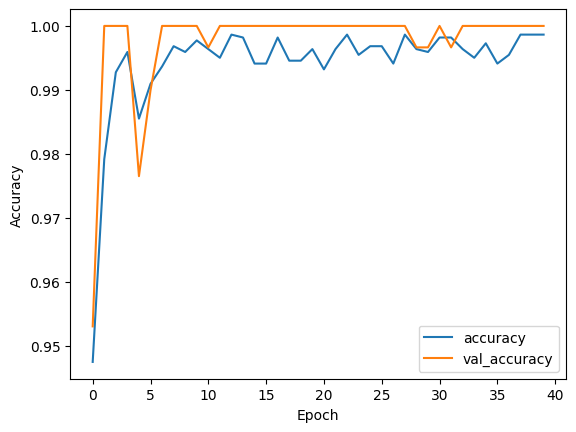

Evaluating the model on validation set...
10/10 [==============================] - 1s 58ms/step - loss: 5.4838e-06 - accuracy: 1.0000
Validation Loss: 0.0000, Validation Accuracy: 1.0000
Predicting on validation set...
10/10 [==============================] - 1s 59ms/step
Classification Report for Validation Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       149
           1       1.00      1.00      1.00       149

    accuracy                           1.00       298
   macro avg       1.00      1.00      1.00       298
weighted avg       1.00      1.00      1.00       298



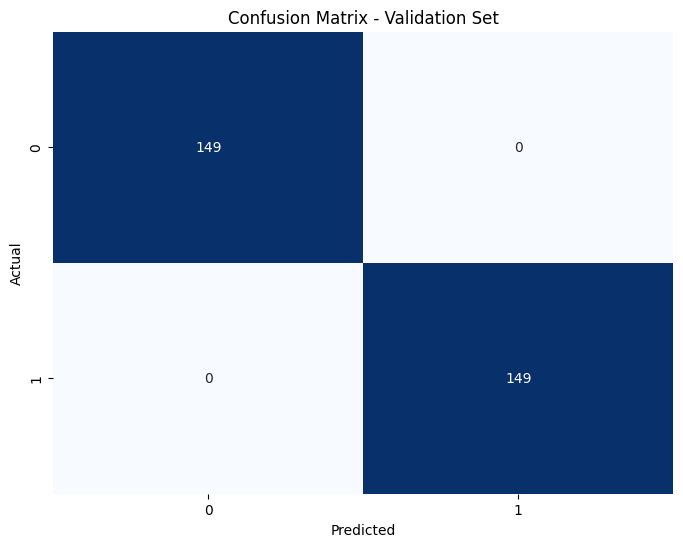

Predicting on test set...
14/14 [==============================] - 1s 59ms/step
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       220
           1       1.00      1.00      1.00       220

    accuracy                           1.00       440
   macro avg       1.00      1.00      1.00       440
weighted avg       1.00      1.00      1.00       440



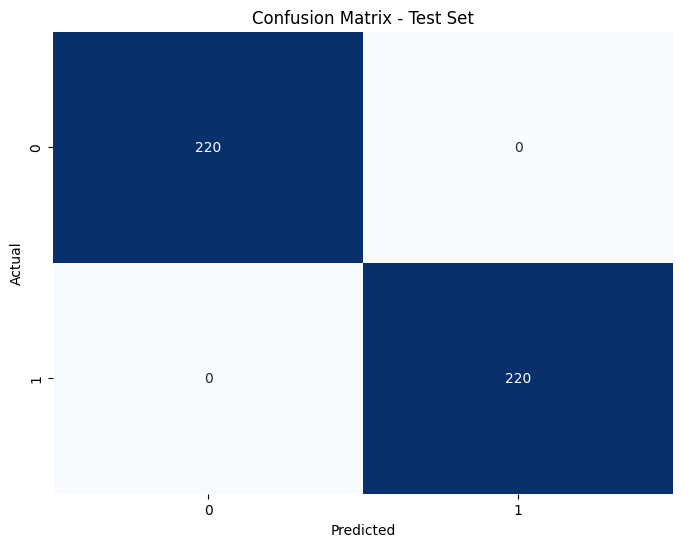

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from efficientnet.tfkeras import EfficientNetB0
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

np.random.seed(42)
tf.random.set_seed(42)

# Define paths to the training, validation, and test directories
train_dir = r'D:\Mushroom dataset\Project database\cnn\splitted\train'
val_dir = r'D:\Mushroom dataset\Project database\cnn\splitted\validation'
test_dir = r'D:\Mushroom dataset\Project database\cnn\splitted\test'

# Define parameters for data generators
batch_size = 32
target_size = (224, 224)  # Target size for input images

# Create ImageDataGenerator instances with data augmentation and normalization for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0,1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation data

# Create train_generator and val_generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',  # Assuming binary classification
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Create ImageDataGenerator instance for test data
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for test data

# Create test_generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Load pre-trained EfficientNetB0 model without top layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model except the last few convolutional layers
for layer in base_model.layers[:-5]:  # Adjust the number of layers to freeze as per your requirement
    layer.trainable = False

# Add custom dense layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(1, activation='sigmoid')(x)  # Binary classification, so using sigmoid activation

# Combine base model with custom top layers
model = models.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=40,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model on validation set
print("Evaluating the model on validation set...")
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Predict on validation set
print("Predicting on validation set...")
val_pred_probs = model.predict(val_generator)
val_preds = (val_pred_probs > 0.5).astype(int)

# Classification report for validation set
print("Classification Report for Validation Set:")
print(classification_report(val_generator.classes, val_preds))

# Confusion matrix for validation set
cm_val = confusion_matrix(val_generator.classes, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Validation Set')
plt.show()

# Predict on test set
print("Predicting on test set...")
test_pred_probs = model.predict(test_generator)
test_preds = (test_pred_probs > 0.5).astype(int)

# Classification report for test set
print("Classification Report for Test Set:")
print(classification_report(test_generator.classes, test_preds))

# Confusion matrix for test set
cm_test = confusion_matrix(test_generator.classes, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')
plt.show()
